# CS 5588 Big Data Analytics and Application
## Hands-On Session: Neural Network Models with PyTorch

In [2]:
# Cell 1: Install required libraries (if not already installed)
!pip install torch torchvision scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
# Cell 2: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
# Cell 3: Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Cell 4: Dataset Preparation
## 4.1 Load and preprocess the California Housing Dataset
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target
print("Initial data shape:", X_housing.shape, y_housing.shape)

# Convert the target to binary for classification
threshold = y_housing.mean()
y_housing_binary = (y_housing > threshold).astype(int)
print("Threshold for classification:", threshold)
print("Binary target values (first 10):", y_housing_binary[:10])

# Train-test split for regression and classification
data_split = train_test_split(
    X_housing, y_housing, y_housing_binary, test_size=0.2, random_state=19
)
X_train_d, X_test_d, y_train_d, y_test_d, y_train_d_binary, y_test_d_binary = data_split
print("Train/Test split shapes:", X_train_d.shape, X_test_d.shape)

# Standardize features
scaler_d = StandardScaler()
X_train_d = scaler_d.fit_transform(X_train_d)
X_test_d = scaler_d.transform(X_test_d)
print("Sample standardized features (first 5 rows):", X_train_d[:5])

# Convert to PyTorch tensors
X_train_d_tensor = torch.tensor(X_train_d, dtype=torch.float32).to(device)
X_test_d_tensor = torch.tensor(X_test_d, dtype=torch.float32).to(device)
y_train_d_tensor = torch.tensor(y_train_d, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_tensor = torch.tensor(y_test_d, dtype=torch.float32).view(-1, 1).to(device)
y_train_d_binary_tensor = torch.tensor(y_train_d_binary, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_binary_tensor = torch.tensor(y_test_d_binary, dtype=torch.float32).view(-1, 1).to(device)

Initial data shape: (20640, 8) (20640,)
Threshold for classification: 2.068558169089147
Binary target values (first 10): [1 1 1 1 1 1 1 1 1 1]
Train/Test split shapes: (16512, 8) (4128, 8)
Sample standardized features (first 5 rows): [[ 0.43749931 -0.13512884 -0.10916829 -0.24565365 -0.32424064  0.0707056
   0.62557109 -1.09480365]
 [-0.80097128  1.53663489 -0.84679797 -0.1121872  -0.71648243 -0.05258381
  -0.71510016  0.64080725]
 [-0.63695903  0.97938032 -0.40654137 -0.17676284 -0.15846639  0.1578479
  -0.71510016  0.73083894]
 [ 0.06721493 -0.21473663 -0.35371877 -0.02691423 -0.2553945  -0.09375552
  -0.67276318  0.53076852]
 [ 0.1408424   0.82016472 -0.16099915 -0.28201984 -0.23908884 -0.05774399
  -0.84681523  0.62580197]]


In [11]:
# Cell 5: Define the Feedforward Neural Network for Regression and Classification
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, classification=False):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        if classification:
            x = self.sigmoid(x)
        return x

# Initialize models
model_regression = FeedforwardNN(X_train_d.shape[1], 1).to(device)
model_classification = FeedforwardNN(X_train_d.shape[1], 1).to(device)
print("Models initialized.")

Models initialized.


In [12]:
# Cell 6: Define Loss Functions and Optimizers
criterion_regression = nn.MSELoss()
criterion_classification = nn.BCELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.001)
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.001)
print("Loss functions and optimizers defined.")

Loss functions and optimizers defined.


In [13]:
# Cell 7: Train the Models
def train_model(model, optimizer, X_train, y_train, criterion, epochs=100, classification=False):
    for epoch in range(epochs):
        model.train()
        inputs = X_train
        targets = y_train

        # Forward pass
        predictions = model(inputs, classification=classification)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Train the Regression model
print("Training Regression Model")
train_model(model_regression, optimizer_regression, X_train_d_tensor, y_train_d_tensor, criterion_regression)

# Train the Classification model
print("Training Classification Model")
train_model(model_classification, optimizer_classification, X_train_d_tensor, y_train_d_binary_tensor, criterion_classification, classification=True)

Training Regression Model
Epoch 10/100, Loss: 4.9105
Epoch 20/100, Loss: 4.1345
Epoch 30/100, Loss: 3.3465
Epoch 40/100, Loss: 2.5238
Epoch 50/100, Loss: 1.8021
Epoch 60/100, Loss: 1.2949
Epoch 70/100, Loss: 1.0017
Epoch 80/100, Loss: 0.8603
Epoch 90/100, Loss: 0.8004
Epoch 100/100, Loss: 0.7655
Training Classification Model
Epoch 10/100, Loss: 0.6574
Epoch 20/100, Loss: 0.6247
Epoch 30/100, Loss: 0.5853
Epoch 40/100, Loss: 0.5408
Epoch 50/100, Loss: 0.4989
Epoch 60/100, Loss: 0.4669
Epoch 70/100, Loss: 0.4445
Epoch 80/100, Loss: 0.4265
Epoch 90/100, Loss: 0.4101
Epoch 100/100, Loss: 0.3952


Regression predictions (first 5): [1.8478969 0.8257786 1.6719216 1.6828071 3.7346811]
Regression Model - MSE: 0.7750, R-squared: 0.4157
Classification predictions (first 5): [ True False False False  True]
Classification Model - Accuracy: 0.8212


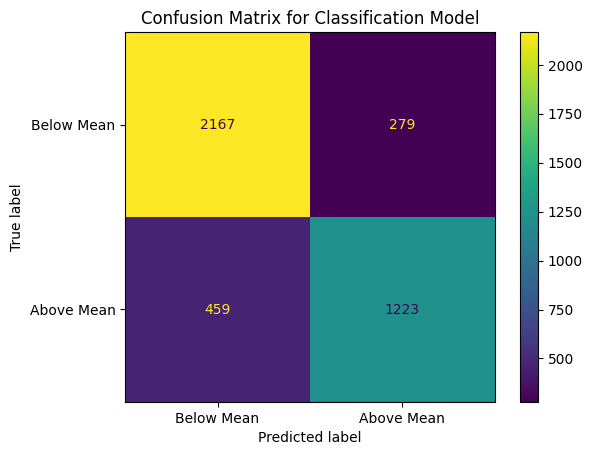

In [14]:
# Cell 8: Evaluate the Models
def evaluate_model_regression(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        mse = mean_squared_error(y_test.cpu().numpy(), predictions)
        r2 = r2_score(y_test.cpu().numpy(), predictions)
        print("Regression predictions (first 5):", predictions[:5].flatten())
    return mse, r2

def evaluate_model_classification(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test, classification=True).cpu().numpy() > 0.5
        accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
        cm = confusion_matrix(y_test.cpu().numpy(), predictions)
        print("Classification predictions (first 5):", predictions[:5].flatten())
    return accuracy, cm

# Evaluate the Regression model
mse_d, r2_d = evaluate_model_regression(model_regression, X_test_d_tensor, y_test_d_tensor)
print(f"Regression Model - MSE: {mse_d:.4f}, R-squared: {r2_d:.4f}")

# Evaluate the Classification model
accuracy_d, cm_d = evaluate_model_classification(model_classification, X_test_d_tensor, y_test_d_binary_tensor)
print(f"Classification Model - Accuracy: {accuracy_d:.4f}")

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=["Below Mean", "Above Mean"]).plot()
plt.title("Confusion Matrix for Classification Model")
plt.show()

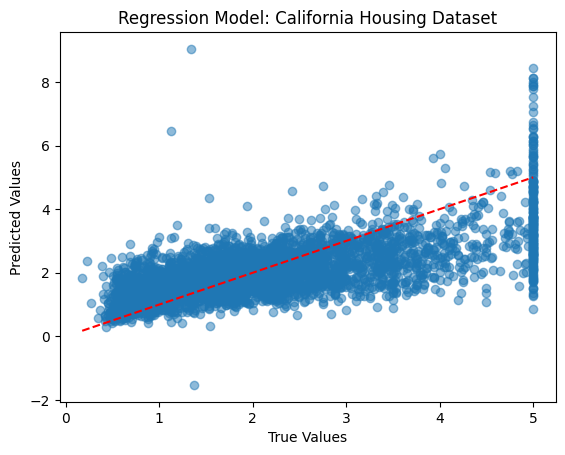

In [15]:
# Cell 9: Visualize the Results
def plot_results_regression(y_test, predictions, title):
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Visualize results for the Regression model
with torch.no_grad():
    predictions_d = model_regression(X_test_d_tensor).cpu().numpy()
    plot_results_regression(y_test_d_tensor.cpu().numpy(), predictions_d, "Regression Model: California Housing Dataset")

In [16]:
# Cell 10: Student Activity
# Task: Implement the same workflow for the California Housing Dataset
# Instructions:
# 1. Load and preprocess the California Housing Dataset (use sklearn's fetch_california_housing).
# 2. Define feedforward neural networks for regression and binary classification (define the threshold for classification).
# 3. Train both models using the same train_model function.
# 4. Evaluate both models using the respective evaluation functions.
# 5. Visualize the predictions for regression and display the confusion matrix for classification.
# 6. Ensure you use the same preprocessing steps and training process.